In [83]:
import IPython
from IPython.display import Audio
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

In [84]:
# from https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs>=min_freq, freqs<=max_freq)] = 1
    return fftnoise(f)

In [85]:
#from https://timsainburg.com/noise-reduction-python.html
#This functions implement a gated spectral noise filter
import time
from datetime import timedelta as td

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)
def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)
def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x,ref=1.0)
def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20,4))
    cax = ax.matshow(signal, origin = 'lower', aspect='auto', cmap=plt.cm.seismic, vmin=-1*np.max(np.abs(signal)), vmax=np.max(np.abs(signal)))
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter):
    fig, ax = plt.subplots(ncols=2, figsize=(20,4))
    plt_mean, = ax[0].plot(mean_freq_noise, label='Mean power of noise')
    plt_std, = ax[0].plot(std_freq_noise, label='Std. power of noise')
    plt_std, = ax[0].plot(noise_thresh, label='Noise threshold (by frequency)')
    ax[0].set_title('Threshold for mask')
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin = 'lower')
    fig.colorbar(cax)
    ax[1].set_title('Filter for smoothing Mask')
    plt.show()
    
def removeNoise(audio_clip, noise_clip, n_grad_freq=2, n_grad_time=4, n_fft=2048, win_length=2048, hop_length=512, n_std_thresh=1.5, prop_decrease=1.0, verbose=False, visual=False):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose: start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length) 
    noise_stft_db = _amp_to_db(np.abs(noise_stft))# convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis =1)
    std_freq_noise = np.std(noise_stft_db, axis =1)
    noise_thresh = mean_freq_noise+std_freq_noise*n_std_thresh
    if verbose: print('STFT on noise:', td(seconds=time.time()-start)); start = time.time()
    # STFT over signal
    if verbose: start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose: print('STFT on signal:',td(seconds=time.time()-start)); start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(np.concatenate([np.linspace(0,1,n_grad_freq+1,endpoint=False),np.linspace(1,0,n_grad_freq+2)])[1:-1], 
                       np.concatenate([np.linspace(0,1,n_grad_time+1,endpoint=False),np.linspace(1,0,n_grad_time+2)])[1:-1])
    smoothing_filter = smoothing_filter/np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(np.reshape(noise_thresh, [1,len(mean_freq_noise)]), np.shape(sig_stft_db)[1], axis = 0).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db<db_thresh
    if verbose: print('Masking:', td(seconds=time.time()-start)); start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter,  mode='same')
    sig_mask = sig_mask*prop_decrease
    if verbose: print('Mask convolution:', td(seconds=time.time()-start)); start = time.time()
    # mask the signal
    sig_stft_db_masked = sig_stft_db *(1-sig_mask) + np.ones(np.shape(mask_gain_dB))*mask_gain_dB*sig_mask # mask real
    sig_imag_masked = np.imag(sig_stft)*(1-sig_mask)
    sig_stft_amp = ((_db_to_amp(sig_stft_db_masked)*np.sign(sig_stft))+(1j * sig_imag_masked) )
    if verbose: print('Mask application:', td(seconds=time.time()-start)); start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(np.abs(_stft(recovered_signal, n_fft, hop_length, win_length)))
    if verbose: print('Signal recovery:', td(seconds=time.time()-start));
    if visual: plot_spectrogram(noise_stft_db, title='Noise')
    if visual: plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter)
    if visual: plot_spectrogram(sig_stft_db, title='Signal')
    if visual: plot_spectrogram(sig_mask, title='Mask applied')
    if visual: plot_spectrogram(sig_stft_db_masked, title='Masked signal')
    if visual: plot_spectrogram(recovered_spec, title='Recovered spectrogram')
    return recovered_signal

In [111]:
#Upload the field data
wav_loc = "bob1.wav"
rate, data= wavfile.read(wav_loc)
data = data/32768
mytime = np.arange(0, len(data)/rate, 1/rate)
len(mytime)==len(data)

True

In [115]:
#Here's what the raw data sounds like
Audio(data[1:rate*15],rate=rate)

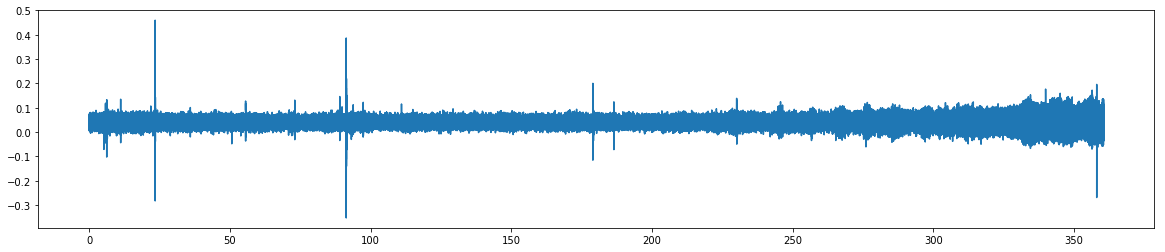

In [88]:
#...and looks like
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(mytime,data)

In [89]:
#Begin filtering. Start by creating a spectrogram and checking that you can invert it back to the original signal
#Parameters for the windowed STFT
n_fft = 2048
hop_length = 512
win_length = 2048

In [90]:
n=len(data)
y_pad = librosa.util.fix_length(data,n + n_fft //2)

noisy_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
#Yep, I can create a windowed FFT and invert it with an error introducted in the 8th sig fig
recovered_signal = librosa.istft(noisy_stft, hop_length=hop_length, win_length=win_length,length = n)
np.max(np.abs(data-recovered_signal))

5.960464477539063e-08

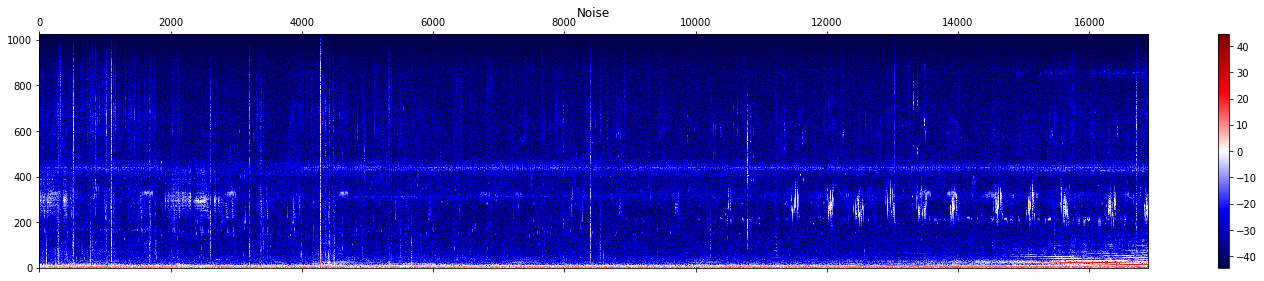

In [91]:
#Here's the raw spectrogram
noise_stft_db = _amp_to_db(np.abs(noisy_stft))# convert to dB
plot_spectrogram(noise_stft_db, title='Noise')

In [92]:
#OK start filtering. Define a butterworth filter for a bandpass. We only need to keep the areas in the
#spectrum where we expect a bobwhite--around 1600-2400 Hz

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [93]:
#Execute the bandpass filter
lowcut = 1600
highcut = 2400
fs = 24000
bandpassed = butter_bandpass_filter(data, lowcut, highcut, fs, order=6)
len(bandpassed)

8651913

In [118]:
#Here's what it sounds like after the bandpass
Audio(bandpassed[1:rate*15],rate=24000)

In [95]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data)
y_pad = librosa.util.fix_length(bandpassed,n + n_fft //2)
bandpassed_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

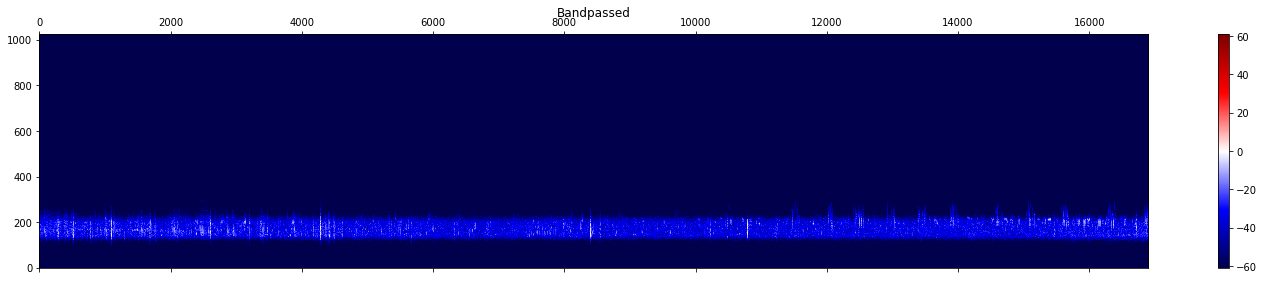

In [96]:
bandpassed_stft_db = _amp_to_db(np.abs(bandpassed_stft))# convert to dB
plot_spectrogram(bandpassed_stft_db, title='Bandpassed')

In [97]:
####just checking...can I still invert it back to an audio signal?
#recovered_signal = librosa.istft(bandpassed_stft, hop_length=hop_length, win_length=win_length,length = n)
#Audio(recovered_signal,rate=24000)

In [98]:
#This code section implements a noise filter. We define a section of background noise, then remove it from the recording.
#Here I define the background noise
silence_begins = int(236.5*rate)
silence_ends = int(238.5*rate)
noise_clip = bandpassed[silence_begins:silence_ends]

STFT on noise: 0:00:00.077681
STFT on signal: 0:00:00.850945
[-89.44373  -89.44356  -89.443146 ... -95.89442  -95.89444  -95.894455] -60.859966
Masking: 0:00:00.499799
Mask convolution: 0:00:17.434099
Mask application: 0:00:04.134290
Signal recovery: 0:00:02.749236


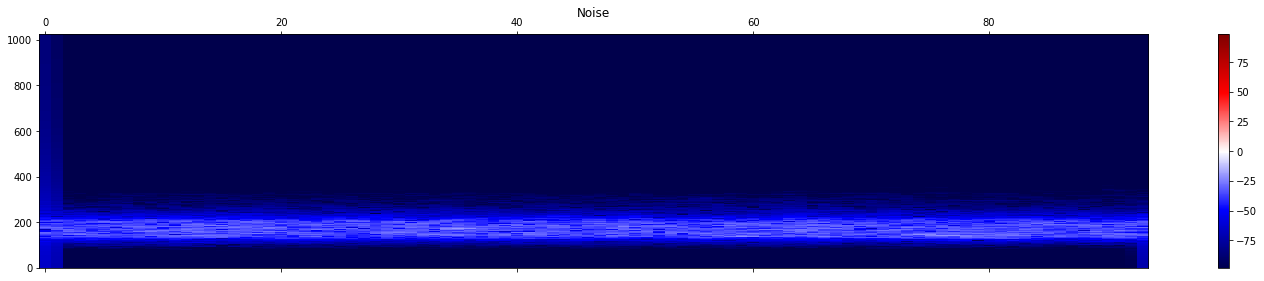

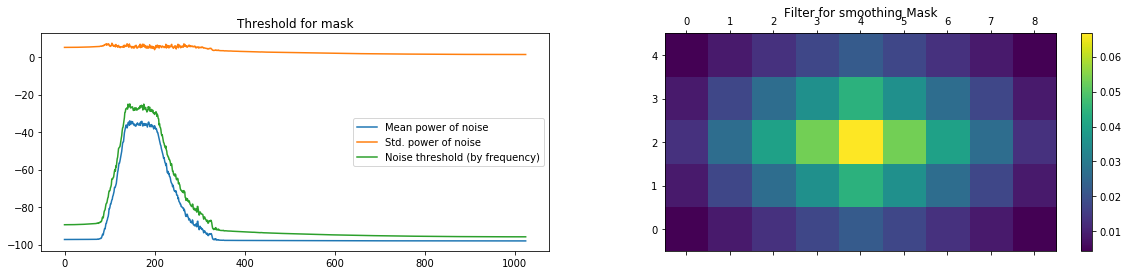

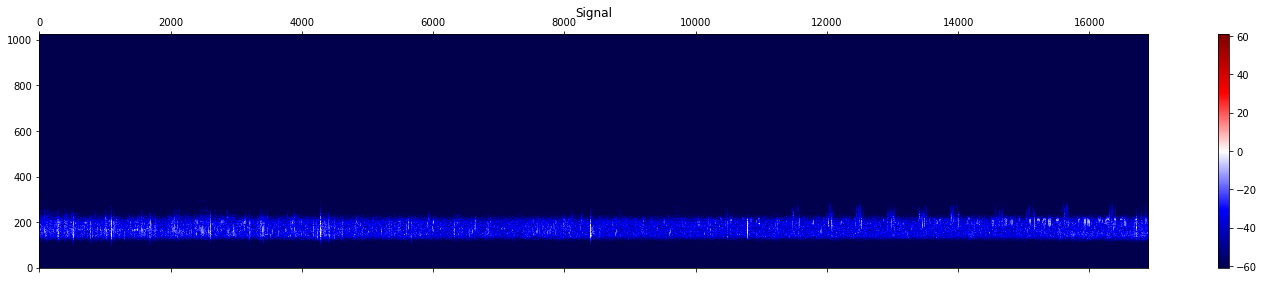

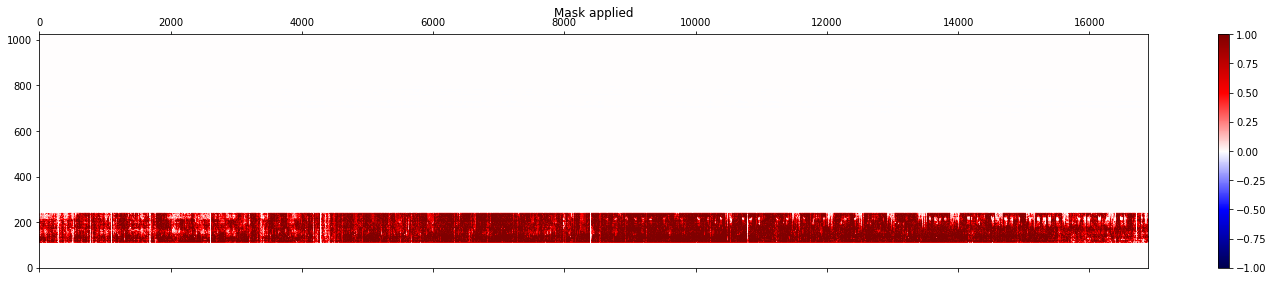

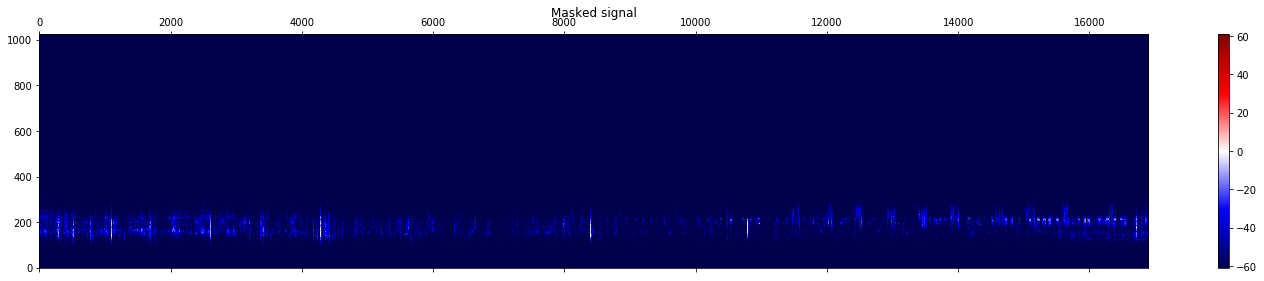

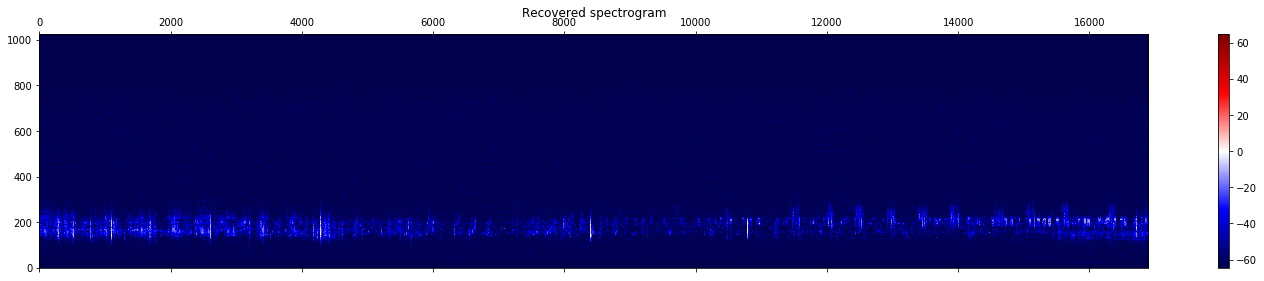

In [99]:
#This removes the background noise
denoised = removeNoise(audio_clip=bandpassed, noise_clip=noise_clip,verbose=True,visual=True)

In [120]:
#Here's what the final audio sounds like after filtering
Audio(denoised[1:15*rate],rate = 24000)

In [101]:
#Write the filtered file
scipy.io.wavfile.write('noise_reduced.wav',rate,denoised)

In [102]:
#Begin detection by importing needed modules
from skimage import data
from skimage.feature import match_template

In [103]:
#Set up the image to be searched
n=len(denoised)
y_pad = librosa.util.fix_length(denoised,n + n_fft //2)
denoised_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
denoised_stft_db = _amp_to_db(np.abs(denoised_stft))# convert to dB

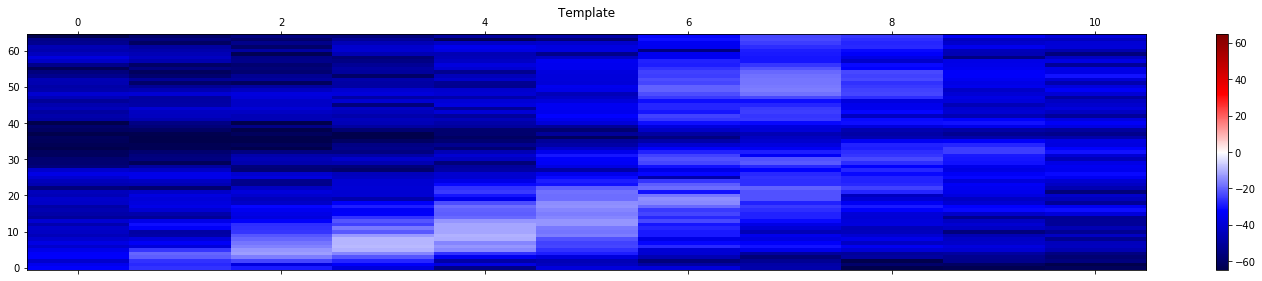

In [104]:
#Define the template as the 'white' portion of a bobwhite call
template_begins = librosa.time_to_frames(159, sr=rate, hop_length=hop_length)
template_ends = librosa.time_to_frames(160, sr=rate, hop_length=hop_length)

template=denoised_stft_db[140:205,template_begins+14:template_ends-22]
plot_spectrogram(template,title='Template')

In [105]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = denoised_stft_db[130:215,:]

In [106]:
#perform a cross correlation between template and scrubbed field recording
result = match_template(image, template)

In [107]:
#perform a local maximum search to find the areas of greatest correlation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.55)


In [108]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000)
sorted(call_times)

[11.605333333333334,
 24.0,
 39.76533333333333,
 51.072,
 65.13066666666667,
 81.64266666666667,
 95.31733333333334,
 101.824,
 107.392,
 119.21066666666667,
 125.80266666666667,
 136.17066666666668,
 136.896,
 145.856,
 148.90666666666667,
 159.296,
 175.296,
 179.968,
 193.70666666666668]

In [109]:
#detection correlations with template
result[x,y]

array([0.55096757, 0.55794915, 0.6068799 , 0.71312257, 0.5822413 ,
       0.60204153, 0.56090447, 0.68461858, 0.99999996, 0.64311192,
       0.65232841, 0.6159981 , 0.65652495, 0.67425256, 0.65709532,
       0.61899381, 0.5921572 , 0.61225437, 0.58769464])